<a href="https://colab.research.google.com/github/Yaakov-Sternberg/AAI-510-Final-Project-Group7/blob/main/USD%2C_ML%2C_Final_Group_Project%2C_EDA_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To Do:
* Wrap preprocessing & FE into scikit-learn-compatible transformers for pipeline integration.

In [ ]:
! pip install umap-learn

# Imports
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from umap import UMAP
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# NLTK download
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab']:
    nltk.download(resource, quiet=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration
CONFIG = {
    "random_state": 42,
    "test_size": 0.4,
    "top_spam_words": 50
}

DATA_PATH = '/content/drive/My Drive/spam_Emails_data.csv'

In [ ]:
# Load data
df = pd.read_csv(DATA_PATH)

# Encode Date
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})

# Split Data
train_df, test_df = train_test_split(
    df,
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"],
    stratify=df['label']
)

TEXT PREPROCESSING

In [ ]:
# Regex & NLP Setup
PATTERNS = {
    "url": re.compile(r"https?://\S+|www\.\S+"),
    "email": re.compile(r"\S+@\S+"),
    "phone": re.compile(r"\b(?:\d{3}[-.\s]?)?\d{3}[-.\s]?\d{4}\b"),
    "currency": re.compile(r"[$\u00A3\u20AC]"),
    "upper_word": re.compile(r"\b[A-Z]{2,}\b"),
    "non_alnum": re.compile(r"[^a-zA-Z0-9\s]"),
    "digit": re.compile(r"\d"),
}
STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

In [ ]:
# Text Preprocessing
def preprocess_text(text: str) -> str:
    """Cleans and tokenizes input text: lowercase, removes noise, lemmatizes."""
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = PATTERNS["url"].sub(" ", text)
    text = PATTERNS["email"].sub(" ", text)
    text = PATTERNS["non_alnum"].sub(" ", text)

    tokens = word_tokenize(text)
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens if t not in STOP_WORDS and len(t) > 1]
    return " ".join(tokens)

# Apply preprocessing to train and test sets
tqdm.pandas()
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text)


100%|██████████| 77541/77541 [02:59<00:00, 432.70it/s]


FEATURE ENGINEERING

In [ ]:
# Feature Engineering

# Spam Vocabulary Builder
def get_spam_vocab(tfidf_matrix, labels, vectorizer, top_n):
    """
    Extracts top-N spam-associated words based on mean TF-IDF scores.
    """
    spam_scores = np.asarray(tfidf_matrix[labels == 1].mean(axis=0)).ravel()
    top_indices = spam_scores.argsort()[::-1][:top_n]
    return set(vectorizer.get_feature_names_out()[top_indices])

# Build Spam Vocabulary
tfidf = TfidfVectorizer(stop_words="english", max_features=5000, min_df=2)
tfidf_matrix = tfidf.fit_transform(train_df["processed_text"])
spam_vocab = get_spam_vocab(tfidf_matrix, train_df["label"].values, tfidf, CONFIG["top_spam_words"])

def create_features(df: pd.DataFrame, spam_vocab: set) -> pd.DataFrame:
    """
    Generates text-based statistical and pattern-based features.
    """
    raw = df["text"].astype(str)
    tokens = df["processed_text"].str.split().fillna("").apply(list)
    features = pd.DataFrame(index=df.index)

    char_count = raw.str.len().clip(lower=1)
    word_count = tokens.str.len().clip(lower=1)

    features["feat_char_count"] = char_count
    features["feat_word_count"] = word_count
    features["feat_sentence_count"] = raw.apply(lambda x: len(sent_tokenize(x))).clip(lower=1)
    features["feat_avg_word_len"] = raw.str.replace(" ", "").str.len() / word_count
    features["feat_word_diversity"] = tokens.apply(lambda x: len(set(x))) / word_count
    features["feat_uppercase_char_ratio"] = raw.str.count(r"[A-Z]") / char_count

    features["feat_exclamation_count"] = raw.str.count("!")
    features["feat_digit_count"] = raw.str.count(PATTERNS["digit"])
    features["feat_special_char_count"] = raw.str.count(fr"[{re.escape(string.punctuation)}]")
    features["feat_currency_symbol_count"] = raw.str.count(PATTERNS["currency"])
    features["feat_uppercase_word_count"] = raw.str.count(PATTERNS["upper_word"])

    features["feat_spam_word_count"] = tokens.apply(lambda t: sum(1 for w in t if w in spam_vocab))
    features["feat_spam_word_ratio"] = features["feat_spam_word_count"] / word_count

    return features.replace([np.inf, -np.inf], 0).fillna(0)

# Create features and join them back to the main dataframes
train_features = create_features(train_df, spam_vocab)
test_features = create_features(test_df, spam_vocab)
train = train_df.join(train_features)
test = test_df.join(test_features)

# EDA & VISUALIZATIONS

## Helper functions

In [ ]:
def _plot_class_distribution(train: pd.DataFrame) -> None:
    """Plot the class (spam/ham) distribution."""
    sns.countplot(
        data=train,
        x=train["label"].map({0: "Ham", 1: "Spam"}),
        palette="pastel",
    )
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


# Top N-Grams Plotter
def plot_top_ngrams(vectorizer, X, labels, label_val, label_name, top_n=15):
    """
    Plots the most frequent n-grams for a given label class.
    """
    vocab = np.array(vectorizer.get_feature_names_out())
    counts = np.asarray(X[labels == label_val].sum(axis=0)).ravel()
    top_idx = counts.argsort()[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts[top_idx], y=vocab[top_idx])
    plt.title(f"Top {top_n} Unigrams in {label_name} Emails")
    plt.xlabel("Count")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

def _plot_top_unigrams(train: pd.DataFrame) -> None:
    """Most frequent unigrams in spam and ham messages (min_df = 3)."""
    vec = CountVectorizer(ngram_range=(1, 1), stop_words="english", min_df=3)
    X_ngram = vec.fit_transform(train["processed_text"])
    for label_val, label_name in [(1, "Spam"), (0, "Ham")]:
        plot_top_ngrams(vec, X_ngram, train["label"].values, label_val, label_name)

def _plot_top_tfidf_scores(tfidf_matrix, vectorizer, top_n=20) -> None:
    """
    Plots the top N terms with the highest mean TF-IDF scores across all documents.
    """
    # Calculate the mean tf-idf score for each term across all documents
    mean_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

    # Get the feature names (terms) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Create a pandas Series for easy sorting and plotting
    tfidf_series = pd.Series(mean_tfidf_scores, index=feature_names)

    # Get the top N terms
    top_terms = tfidf_series.sort_values(ascending=False).head(top_n)

    # Plot the results
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_terms.values, y=top_terms.index, palette="viridis")
    plt.title(f"Top {top_n} Terms by Mean TF-IDF Score")
    plt.xlabel("Mean TF-IDF Score")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

def _plot_top_mi_terms(tfidf_matrix, vectorizer, labels, top_n=10) -> None:
    """
    Calculates and plots the top N most informative terms based on Mutual Information.
    """
    # Calculate Mutual Information scores between each term (feature) and the labels
    mi_scores = mutual_info_classif(
        tfidf_matrix,
        labels,
        random_state=CONFIG["random_state"]
    )

    # Get the feature names (terms) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Create a pandas Series for easy sorting and plotting
    mi_series = pd.Series(mi_scores, index=feature_names)

    # Get the top N terms and sort them for plotting
    top_terms = mi_series.sort_values(ascending=False).head(top_n).sort_values(ascending=True)

    # Plot the results
    plt.figure(figsize=(10, 6))
    top_terms.plot.barh(color="c")
    plt.title(f"Top {top_n} Most Informative Terms (Mutual Information)")
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()


def _plot_feature_distributions(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Boxplots of every engineered feature, split by class, with log-scale where needed."""
    n_cols = 3
    n_rows = (len(feature_cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    fig.suptitle("Feature Distributions (Spam vs Ham)", fontsize=18, y=1.02)
    axes = axes.flatten()

    for ax, col in zip(axes, feature_cols):
        sns.boxplot(
            data=train,
            x=train["label"].map({0: "Ham", 1: "Spam"}),
            y=col,
            ax=ax,
            showfliers=False,
        )
        if train[col].skew() > 3:
            ax.set_yscale("log")
            ax.set_title(f"{col} (Log Scale)")
        else:
            ax.set_title(col)
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    # Remove empty subplots
    for i in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


def _plot_mutual_information(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Bar chart of the top-15 most informative engineered features."""
    X = train[feature_cols]
    y = train["label"]
    mi_scores = mutual_info_classif(X, y, random_state=CONFIG["random_state"])
    mi_series = (
        pd.Series(mi_scores, index=X.columns)
        .sort_values(ascending=False)
        .head(15)
        .sort_values()
    )
    mi_series.plot.barh(figsize=(10, 6), color="skyblue")
    plt.title("Top 15 Informative Features")
    plt.xlabel("Mutual Information")
    plt.tight_layout()
    plt.show()


def _plot_correlation_heatmap(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Upper-triangle heat-map of feature–feature correlations."""
    corr = train[feature_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()

def _plot_umap(train: pd.DataFrame, tfidf_matrix) -> None:
    """2-D UMAP embedding of the TF-IDF matrix, colored by class."""
    umap_model = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=CONFIG["random_state"],
    )
    embedding = umap_model.fit_transform(tfidf_matrix)

    umap_df = pd.DataFrame(embedding, columns=["umap_1", "umap_2"])
    umap_df["label"] = train["label"].map({0: "Ham", 1: "Spam"}).values

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=umap_df,
        x="umap_1",
        y="umap_2",
        hue="label",
        alpha=0.7,
    )
    plt.title("UMAP Visualization of TF-IDF Features")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()

## EDA Outputs

<ipython-input-12-51e2375c3d9c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


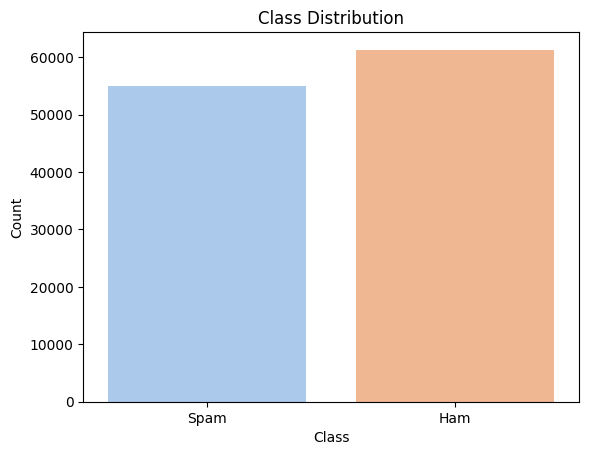

In [ ]:
_plot_class_distribution(train)

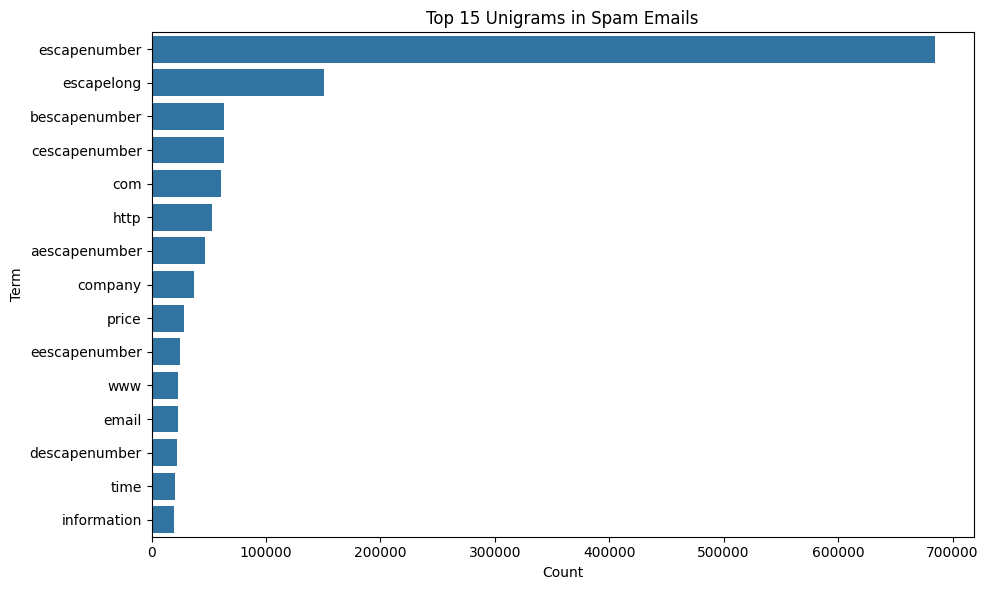

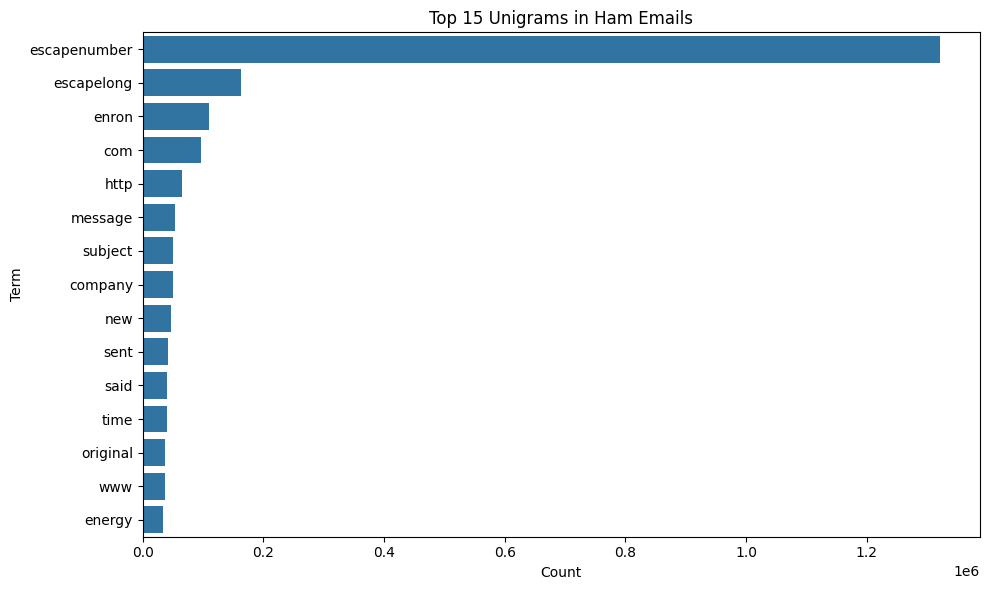

In [ ]:
_plot_top_unigrams(train)

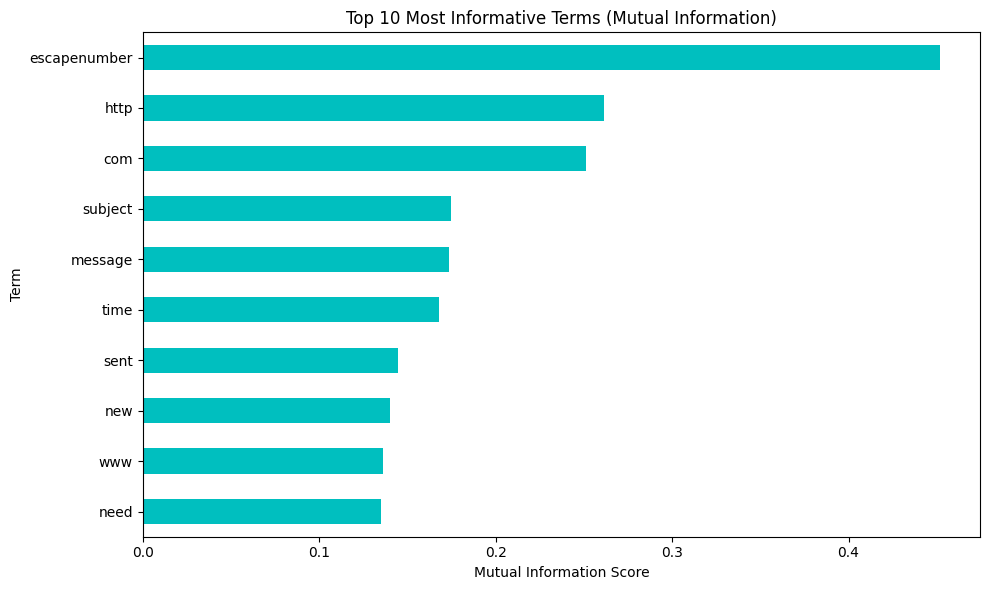

In [ ]:
_plot_top_mi_terms(tfidf_matrix, tfidf, train_df['label'])

List top spam terms

In [ ]:
print(f"Top {CONFIG['top_spam_words']} Spam Terms: {sorted(list(spam_vocab))}")

Top 50 Spam Terms: ['adobe', 'aescapenumber', 'bescapenumber', 'best', 'buy', 'cescapenumber', 'cialis', 'click', 'com', 'company', 'customer', 'day', 'drug', 'email', 'escapelong', 'escapenumber', 'free', 'http', 'info', 'information', 'life', 'like', 'low', 'mail', 'medication', 'money', 'need', 'net', 'new', 'news', 'offer', 'online', 'order', 'php', 'pill', 'price', 'product', 'professional', 'quality', 'save', 'service', 'site', 'software', 'statement', 'time', 'viagra', 'visit', 'want', 'watch', 'www']


UMAP & t-SNE

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


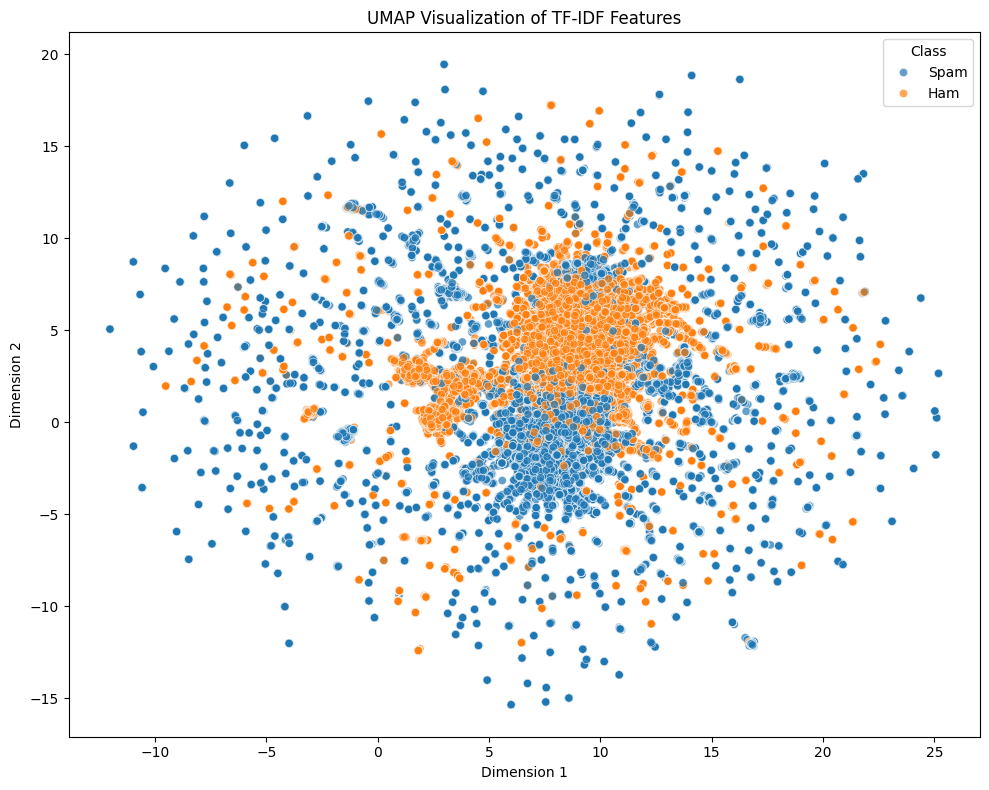

In [ ]:
_plot_umap(train, tfidf_matrix)

# t-SNE outputs from other runs

t-SNE using all 5K Features (EDA Version 3)

In [ ]:
scaler = StandardScaler(with_mean=False)
tfidf_scaled = scaler.fit_transform(tfidf_matrix)
tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=CONFIG["random_state"])
embedding = tsne.fit_transform(tfidf_scaled.toarray())

tsne_df = pd.DataFrame({
    "tsne_1": embedding[:, 0],
    "tsne_2": embedding[:, 1],
    "label": train["label"].map({0: "Ham", 1: "Spam"})
})

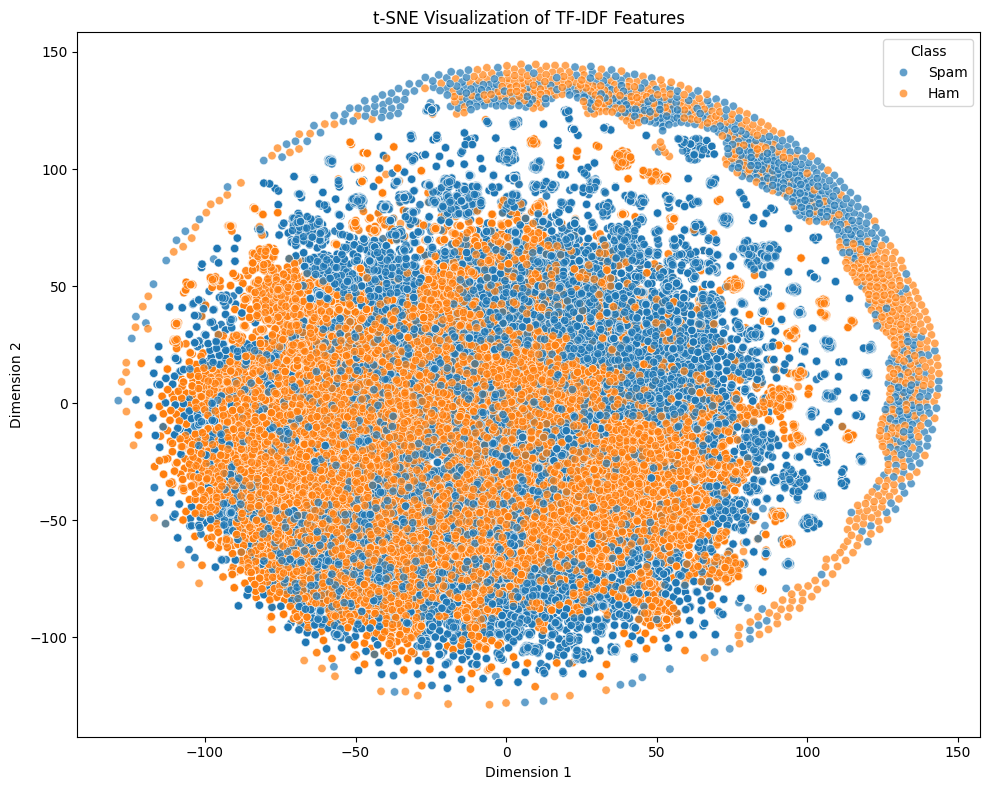

Using only 1K Features (from EDA version 4)

In [ ]:
# 1. A new vectorizer is created specifically for this visualization
tfidf_viz = TfidfVectorizer(stop_words="english", max_features=1000) # Used only 1K Features
X_tfidf_viz = tfidf_viz.fit_transform(train["processed_text"]) # Use all training data

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_tfidf_viz)

tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=RANDOM_STATE)

# 2. t-SNE is run on the entire scaled dataset
embedding = tsne.fit_transform(X_scaled.toarray())

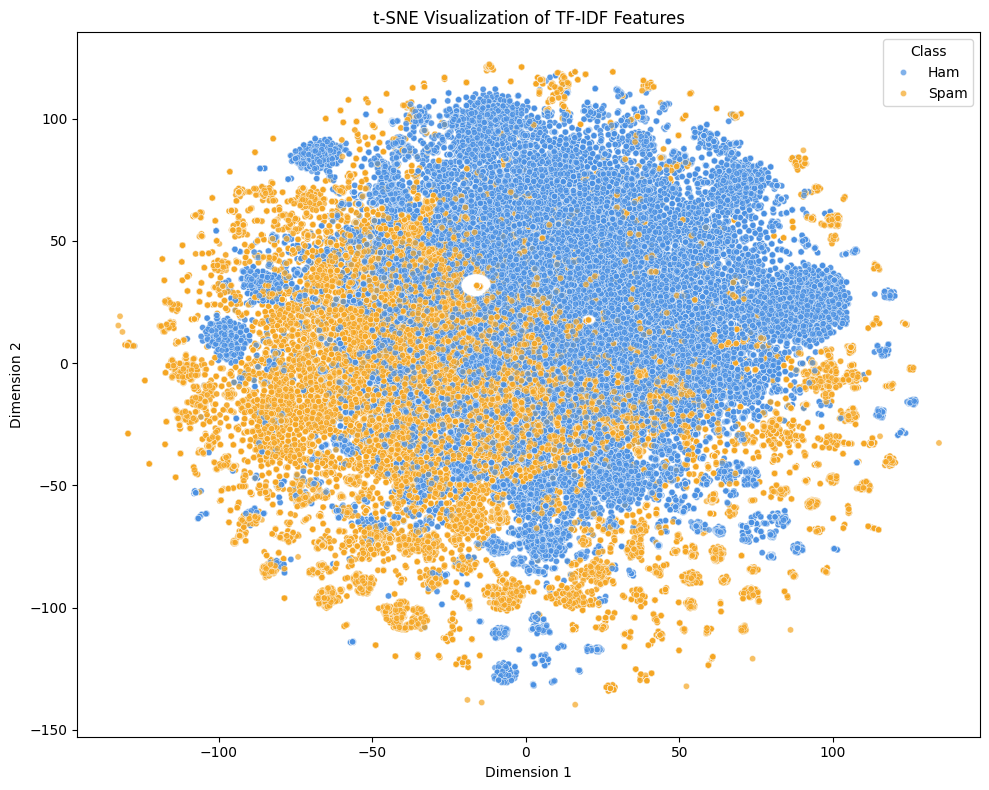

# Visualizations for other non-IF-IDF Features

<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


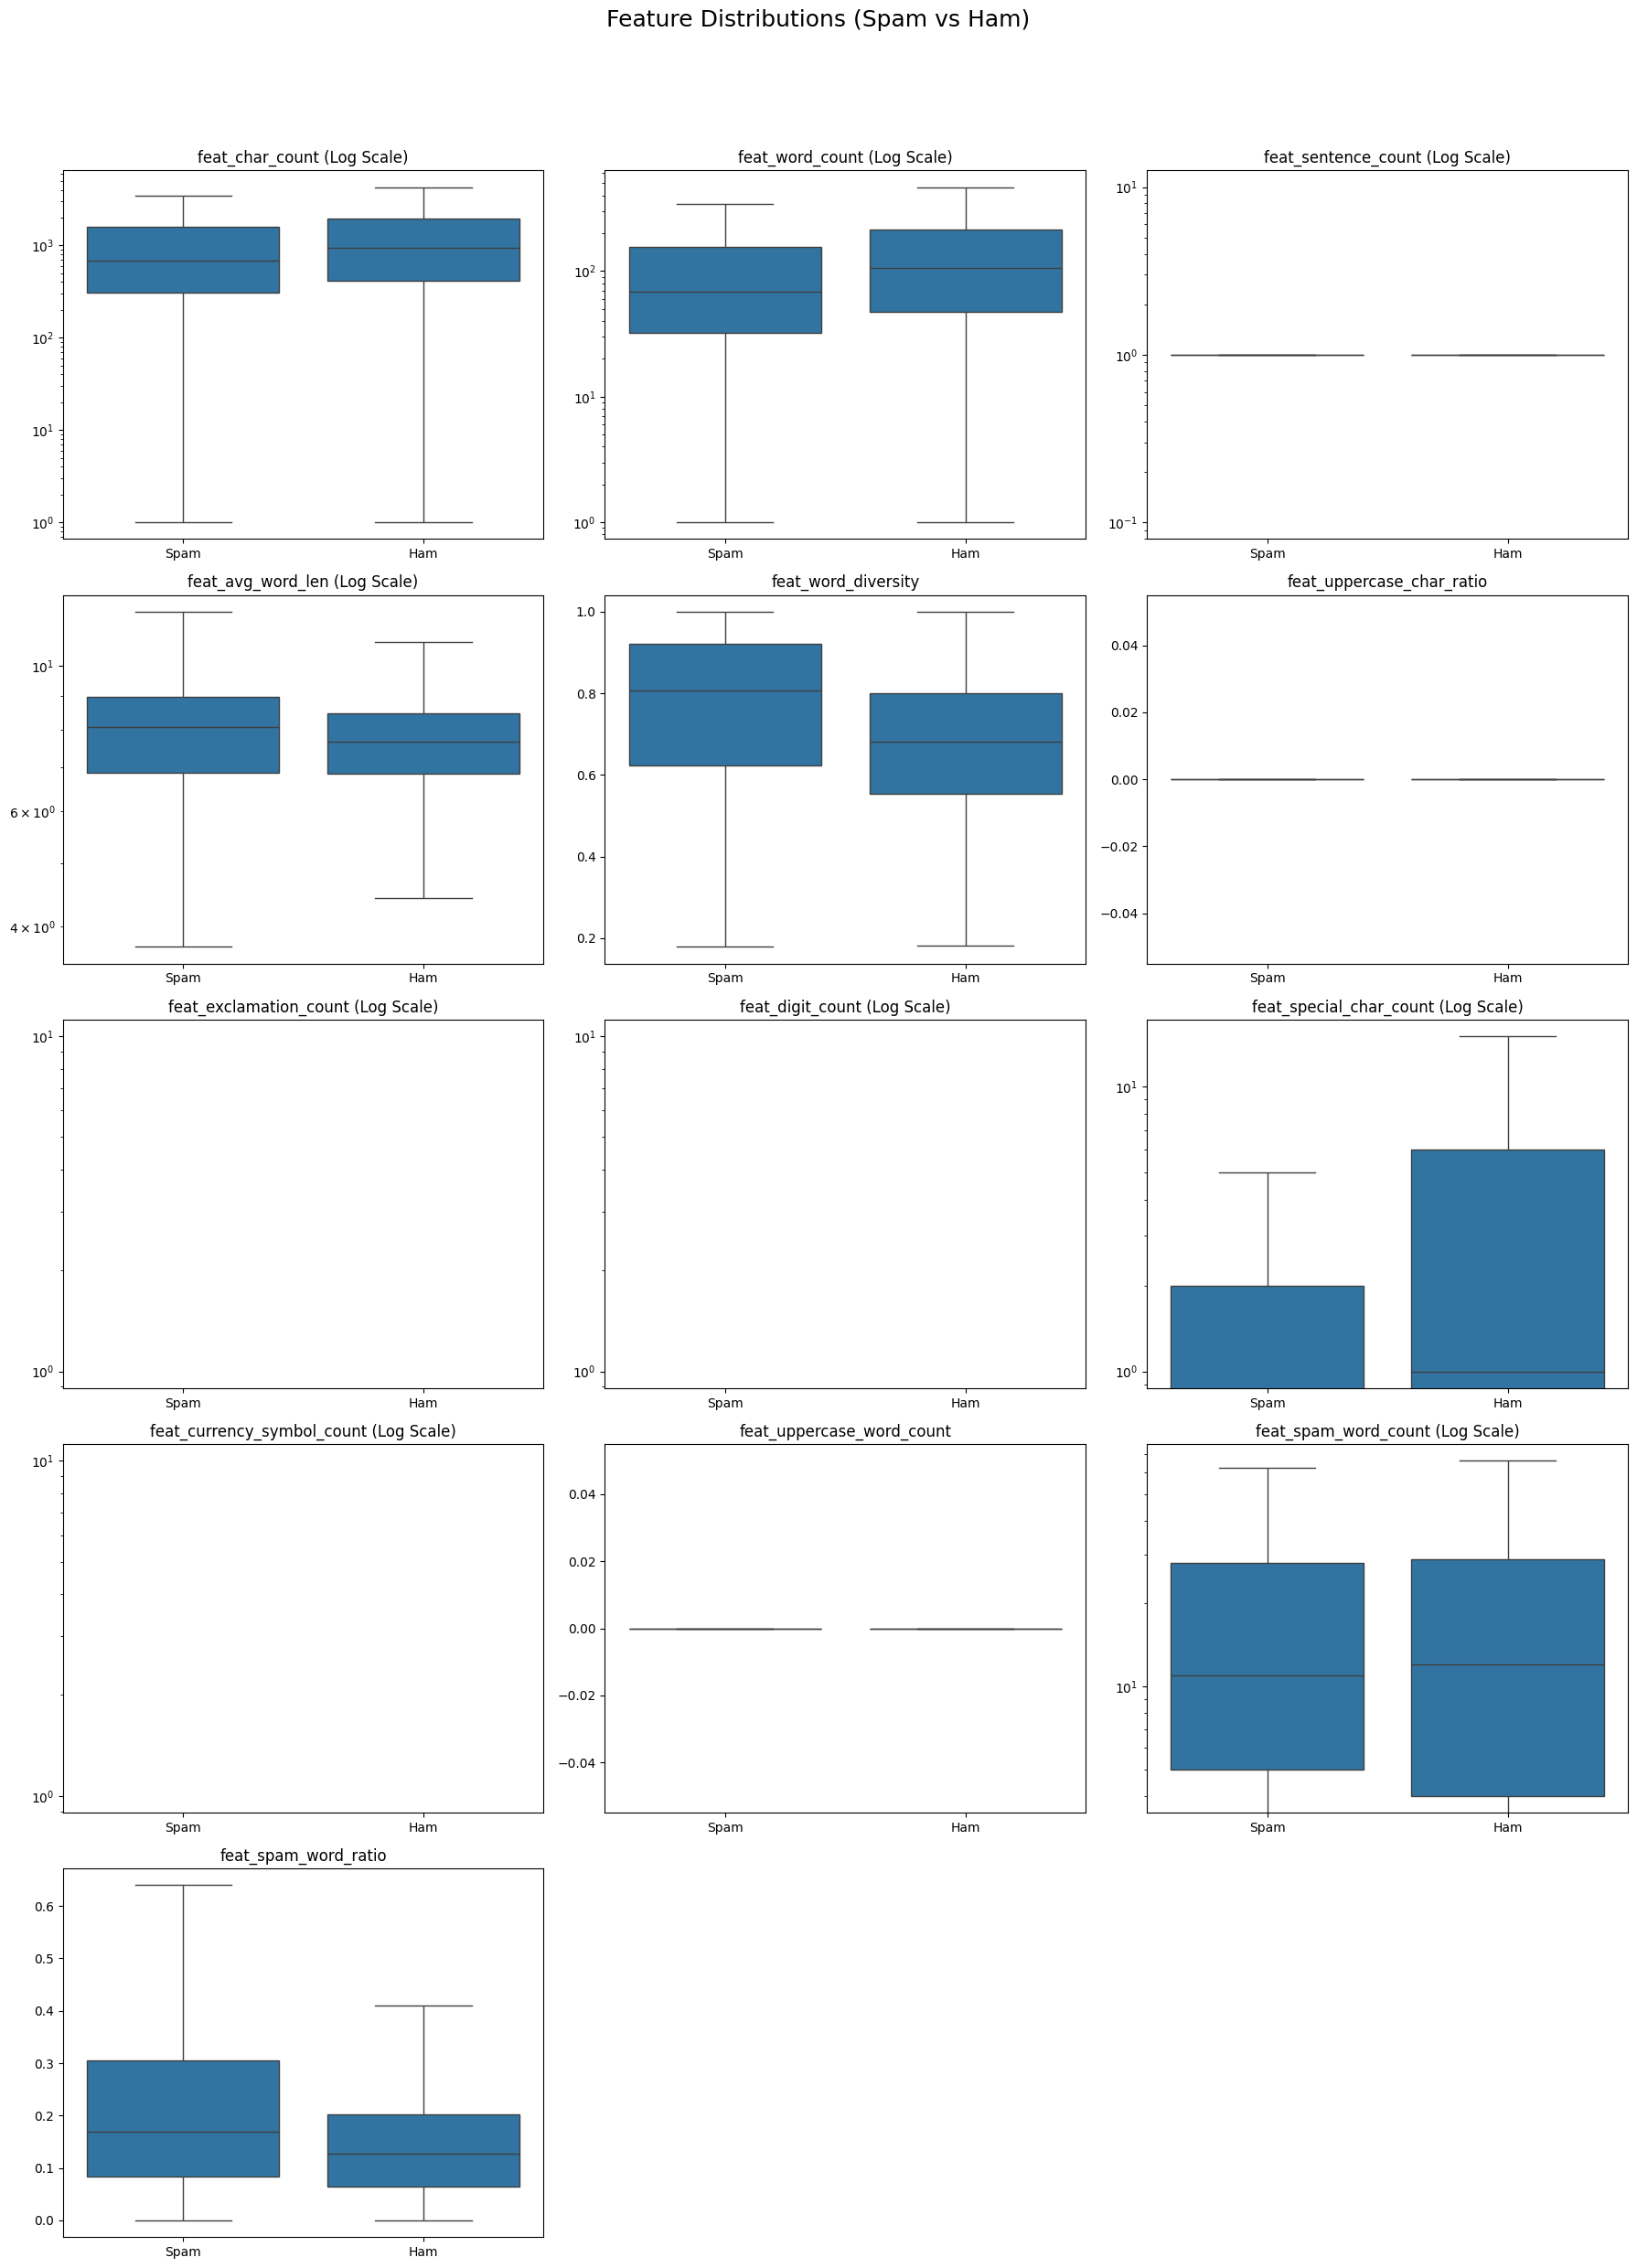

In [ ]:
feature_cols = [c for c in train.columns if c.startswith("feat_")]
_plot_feature_distributions(train, feature_cols)

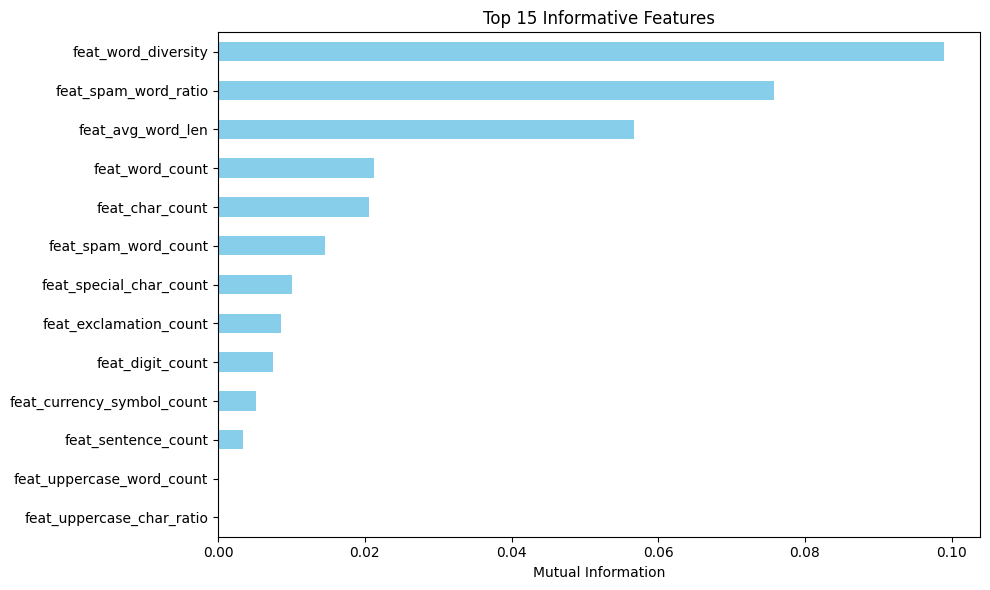

In [ ]:
_plot_mutual_information(train, feature_cols)

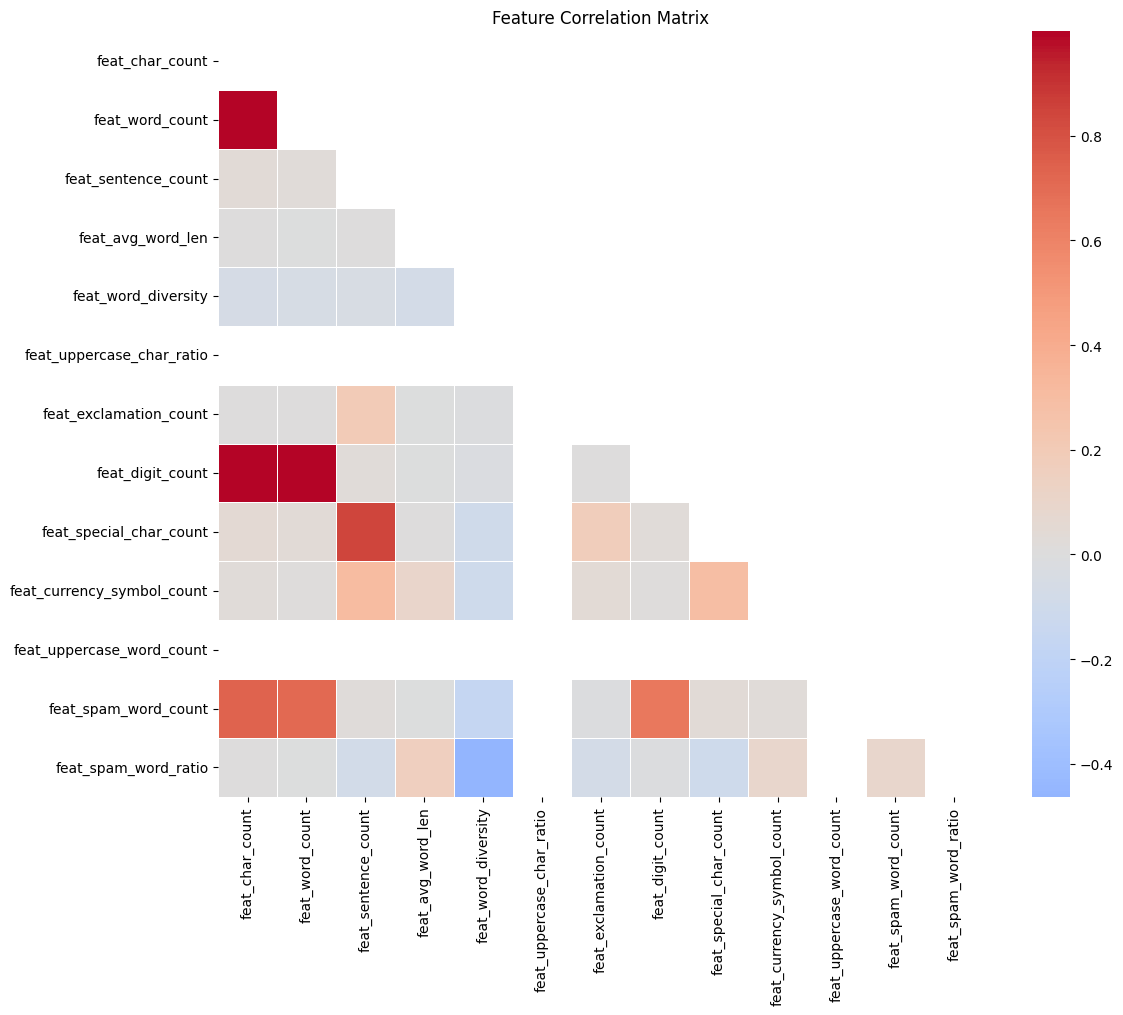

In [ ]:
_plot_correlation_heatmap(train, feature_cols)



---


**Assistance Disclosure:**

I used LLMs (Codey, ChatGPT, Gemini, Claude, Grok) for brainstorming, debugging, feedback, and improving code readability.